In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [43]:
max_l = 10
l_bins = int((max_l/2)+1)
n=35
m=10

## Create QPM Matrices

In [10]:
full_minmock = 1
full_maxmock = 1000
N_full = full_maxmock - full_minmock + 1

In [15]:
qpm_dir = '/mnt/store1/oliverphilcox/QPM_Full2/'
t = loadtxt(qpm_dir+'0001_corr.dat')
rr = t[:,-1]
N_bins = len(rr)
input_mu = t[:,0]
m=len(np.unique(input_mu))
input_r = t[:,1]
n = len(np.unique(input_r))
all_r = np.unique(input_r)
all_mu = np.unique(input_mu)
dd=t[:,-3]

In [17]:
sumW_DD = np.load('/mnt/store1/oliverphilcox/DR12_QPM/sumW_DD.npy')
mock1 = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/processed/qpm_galaxy_1.xyzwj')
sumW = np.sum(mock1[:,3])
dd_cf = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/DDcounts.dat')

In [19]:
rand1 = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/qpm_randoms_10x.xyzwj')
sumWran = np.sum(rand1[:,3])
rr_cf = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/RRcounts_n45_m10.dat')*sumWran**2.
rand_ratio=np.sqrt(np.mean(rr/rr_cf*2))

In [20]:
sumRR=sumWran*np.mean(np.sqrt((2.*rr)/(rr_cf)))

In [25]:
full_xi_qpm = zeros((N_full,N_bins))
N_gal_ratio = zeros((N_full))

for i in range(full_minmock,full_maxmock+1):
    mocknum = str(i).zfill(4)
    t = loadtxt(qpm_dir+mocknum+'_corr.dat')
    dd = t[:,-3]
    dr = t[:,-2]
    
    j = i - full_minmock
    
    this_rr = rr/sumRR**2.
    this_dr = dr/(sumRR*sumW_DD[j])
    this_dd = dd/sumW_DD[j]**2.
    
    full_xi_qpm[j] = this_dd/this_rr-this_dr/this_rr+1.

#### Define full $(r,\mu)$ QPM covariance

In [34]:
all_mocks = full_xi_qpm[:,100:] # excluding first 100 bins
n_mocks = len(all_mocks)

mean_xi = np.mean(all_mocks,axis=0)
diff = all_mocks-mean_xi
qpm_covariance_rmu = np.matmul(diff.T,diff)/(n_mocks-1.)

#### Define Legendre QPM Covariance

In [110]:
from scipy.special import legendre
all_mocks_Legendre = np.zeros([n_mocks,l_bins*n])
for r_a in range(n):
    these_bins=all_mocks[:,r_a*m:(r_a+1)*m]
    for p_i in range(l_bins):
        p_moment = 2*p_i
        all_mocks_Legendre[:,r_a*l_bins+p_i]=(2*p_moment+1)*np.sum(legendre(p_moment)(all_mu)*these_bins,axis=1)/len(all_mu)

In [111]:
mean_xi_Legendre = np.mean(all_mocks_Legendre,axis=0)
diff_Legendre = all_mocks_Legendre-mean_xi_Legendre
qpm_covariance_Legendre = np.matmul(diff_Legendre.T,diff_Legendre)/(n_mocks-1.)

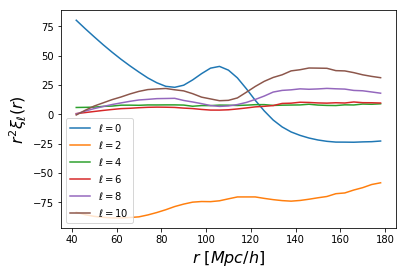

In [114]:
for i in range(l_bins):
    plt.plot(all_r[10:],all_r[10:]**2.*all_mocks_Legendre[:,i::6].mean(axis=0),label=r'$\ell = %d$'%(i*2))
plt.ylabel(r'$r^2 \xi_\ell(r)$',fontsize=16);plt.xlabel(r'$r\,\, [Mpc/h]$',fontsize=16);plt.legend();

In [115]:
def rebinner(in_matrix):
    out_matrix = np.zeros_like(in_matrix)
    for r_a in range(n):
        for r_b in range(n):
            for p_i in range(l_bins):
                for q_i in range(l_bins):
                    out_matrix[p_i*n+r_a,q_i*n+r_b]=in_matrix[r_a*l_bins+p_i,r_b*l_bins+q_i]
    return out_matrix

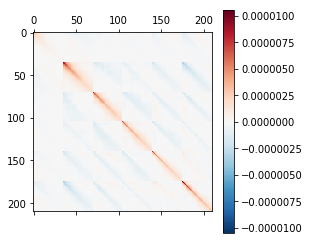

In [116]:
mat=rebinner(qpm_covariance_Legendre)
vmax=max(mat.ravel())
plt.matshow(rebinner(qpm_covariance_Legendre),vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

In [6]:
xi_file = '/mnt/store1/oliverphilcox/QPM_xi/'
xis=[]
for mock_no in range(1,100):
    xis.append(np.loadtxt(xi_file+'QPM_mock_%d.xi'%mock_no,skiprows=2))

In [ ]:
r_xi = 

In [9]:
xis[0].shape

(59, 24)

#### Load $(r,\mu)$ and Legendre matrices

In [49]:
work_dir = '/mnt/store1/oliverphilcox/Legendre2PCF/CovMatricesAll/'

In [133]:
c2l = np.loadtxt(work_dir+'c2_leg_n35_l10_11_full.txt')
c3l = np.loadtxt(work_dir+'c3_leg_n35_l10_1,11_full.txt')
c4l = np.loadtxt(work_dir+'c4_leg_n35_l10_11,11_full.txt')

In [134]:
c2f = np.diag(np.loadtxt(work_dir+'c2_n35_m10_11_full.txt'))
c3f = np.loadtxt(work_dir+'c3_n35_m10_1,11_full.txt')
c4f = np.loadtxt(work_dir+'c4_n35_m10_11,11_full.txt')

In [135]:
cl_tot = c2l+c3l+c4l
cf_tot = c2f+c3f+c4f

#### Find Legendre approximation from $(r,\mu)$ matrix

In [136]:
from scipy.special import legendre

In [137]:
mu_cen = np.arange(0.05,1.05,0.1)
n=35
m=10

In [138]:
l_bins=6
cf_legendre = np.zeros_like(cl_tot)
for p_i in range(l_bins):
    legendre_p = p_i*2
    for q_i in range(l_bins):
        legendre_q = q_i*2
        all_factors = np.matmul(legendre(legendre_p)(mu_cen).reshape(-1,1),legendre(legendre_q)(mu_cen).reshape(1,-1))
        for r_a in range(n):
            for r_b in range(n):
                this_cov = cf_tot[m*r_a:m*(r_a+1),m*r_b:m*(r_b+1)]
                cf_legendre[r_a*l_bins+p_i,r_b*l_bins+q_i]=np.sum(all_factors*this_cov)*(1./m)**2.*(2.*legendre_p+1)*(2.*legendre_q+1)

In [139]:
ind_cov_full_legendre=[]
for i in range(l_bins):
    ind_cov_full_legendre.append(cf_legendre[i::l_bins,i::l_bins])

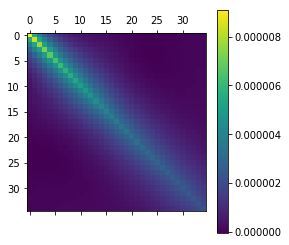

In [140]:
plt.matshow(ind_cov_full_legendre[2]);plt.colorbar();

In [141]:
ind_cov_legendre=[]
for i in range(l_bins):
    ind_cov_legendre.append(cl_tot[i::l_bins,i::l_bins])

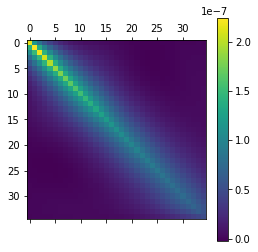

In [142]:
plt.matshow(ind_cov_legendre[2]);plt.colorbar()

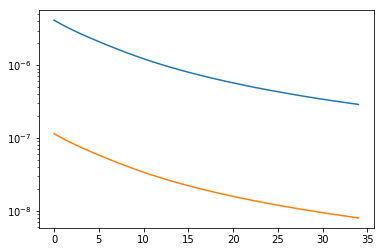

In [176]:
plt.plot(np.diag(ind_cov_full_legendre[0]),label='Full Matrix')
plt.plot(np.diag(ind_cov_legendre[0]),label='Legendre Matrix')
plt.yscale('log')

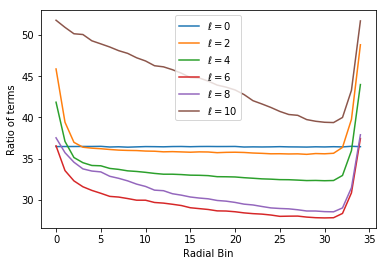

In [177]:
for i in range(6):
    plt.plot(np.diag(ind_cov_full_legendre[i])/np.diag(ind_cov_legendre[i]),label=r'$\ell = %d$'%(2*i))
plt.ylabel('Ratio of terms')
plt.xlabel('Radial Bin');
plt.legend();

#### Display matrix in other ordering;

In [149]:
cl_tot_reordered = np.zeros_like(cl_tot)
for r_a in range(n):
    for r_b in range(n):
        for p_i in range(l_bins):
            for q_i in range(l_bins):
                cl_tot_reordered[p_i*n+r_a,q_i*n+r_b]=cf_legendre[r_a*l_bins+p_i,r_b*l_bins+q_i]

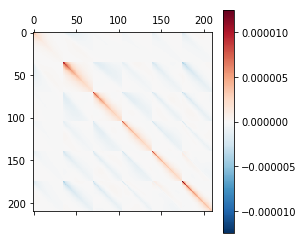

In [150]:
vmax=max(cl_tot_reordered.ravel())
plt.matshow(cl_tot_reordered,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax);plt.colorbar();

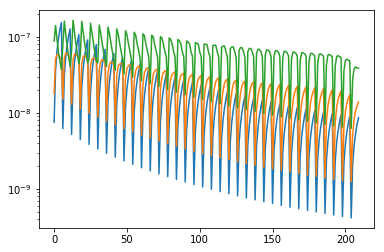

In [152]:
plt.plot(np.diag(c2l))
plt.plot(np.diag(c3l))
plt.plot(np.diag(c4l))
plt.yscale('log');